In [19]:
def remove_duplicates_from_file(input_file_path, output_file_path=None):
    if output_file_path is None:
        output_file_path = input_file_path
    
    with open(input_file_path, 'r') as file:
        image_names = file.readlines()

    unique_names = set(name.strip() for name in image_names)

    with open(output_file_path, 'w') as file:
        for name in sorted(unique_names):  
            file.write(name + '\n')

input_file_path = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_unimodal.txt'
output_file_path = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_unimodal.txt'  # You can use the same path to overwrite
remove_duplicates_from_file(input_file_path, output_file_path)

In [25]:
import pandas as pd

def read_and_categorize(file_path):
    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]
    categories = {
        'GL_': 0,
        'SD_': 0,
        'DL_': 0,
        'Other': 0
    }
    for name in names:
        if name.startswith('GL_'):
            categories['GL_'] += 1
        elif name.startswith('SD_'):
            categories['SD_'] += 1
        elif name.startswith('DL_'):
            categories['DL_'] += 1
        else:
            categories['Other'] += 1
    return names, categories

def find_common_and_categorize(names1, names2):
    common_names = set(names1).intersection(set(names2))
    categories = {
        'GL_': 0,
        'SD_': 0,
        'DL_': 0,
        'Other': 0
    }
    for name in common_names:
        if name.startswith('GL_'):
            categories['GL_'] += 1
        elif name.startswith('SD_'):
            categories['SD_'] += 1
        elif name.startswith('DL_'):
            categories['DL_'] += 1
        else:
            categories['Other'] += 1
    return categories

file_path1 = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_unimodal.txt'
file_path2 = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_multimodal.txt'

names1, categories1 = read_and_categorize(file_path1)
names2, categories2 = read_and_categorize(file_path2)
common_categories = find_common_and_categorize(names1, names2)

df = pd.DataFrame({
    'Category': ['Glide', 'Stable Diffusion', 'Dreamlike', 'Pristine'],
    'Unimodal Misclassified': [categories1['GL_'], categories1['SD_'], categories1['DL_'], categories1['Other']],
    'Multimodal Misclassified': [categories2['GL_'], categories2['SD_'], categories2['DL_'], categories2['Other']],
    'Common Misclassified': [common_categories['GL_'], common_categories['SD_'], common_categories['DL_'], common_categories['Other']]
})

print(df)

           Category  Unimodal Misclassified  Multimodal Misclassified  \
0             Glide                     789                       716   
1  Stable Diffusion                     999                       907   
2         Dreamlike                     585                       513   
3          Pristine                    3739                      3497   

   Common Misclassified  
0                   423  
1                   230  
2                   144  
3                  2086  


In [ ]:
import matplotlib.image as mpimg
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

def find_common(names1, names2):
    return set(names1).intersection(set(names2))

def categorize(images_names):
    categories = {
        'Glide': [],
        'Stable Diffusion': [],
        'Dreamlike': [],
        'Pristine': []
    }
    for name in images_names:
        if name.startswith('GL_'):
            categories['Glide'].append(name)
        elif name.startswith('SD_'):
            categories['Stable Diffusion'].append(name)
        elif name.startswith('DL_'):
            categories['Dreamlike'].append(name)
        else:
            categories['Pristine'].append(name)
    return categories


def load_captions(caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    return caption_dict

def read_and_categorize_with_examples(file_path): 
    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]
    categories = {
        'Glide': [],
        'Stable Diffusion': [],
        'Dreamlike': [],
        'Pristine': []
    }
    for name in names:
        key = None
        if name.startswith('GL_'):
            key = 'Glide'
        elif name.startswith('SD_'):
            key = 'Stable Diffusion'
        elif name.startswith('DL_'):
            key = 'Dreamlike'
        else:
            key = 'Pristine'
        categories[key].append(name) 
    return names, categories

def find_unique(names1, names2):
    """Find images misclassified by unimodal but not multimodal"""
    return set(names1) - set(names2)

def display_images_for_category(categories, title, captions, num_images=3):
    fig, axs = plt.subplots(num_images, 4, figsize=(20, 10))
    fig.suptitle(title)
    
    if num_images == 1:
        axs = axs.reshape(1, 4)
    else:
        axs = axs.reshape(num_images, 4)

    for i, key in enumerate(['Glide', 'Stable Diffusion', 'Dreamlike', 'Pristine']):
        available_images = categories[key]
        random.shuffle(available_images)  # Shuffle images each time
        displayed_images = available_images[:num_images] if len(available_images) >= num_images else []
        
        for j, image_name in enumerate(displayed_images):
            image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{image_name}.jpg'
            img = mpimg.imread(image_path)
            axs[j, i].imshow(img, aspect='equal')
            caption = captions.get(image_name.split('.')[0], "Caption not found")
            wrapped_caption = textwrap.fill(caption, width=40)
            axs[j, i].set_title(f'{key} Sample {j+1}: {image_name}\n{wrapped_caption}', fontsize=10)
            axs[j, i].axis('off')
            axs[j, i].set_xlim(0, img.shape[1])
            axs[j, i].set_ylim(img.shape[0], 0)
        if len(displayed_images) < num_images:
            for j in range(len(displayed_images), num_images):
                axs[j, i].axis('off')
    
    plt.tight_layout()
    plt.show()

file_path1 = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_unimodal.txt'
file_path2 = '/home/enriconello/DeepFakeDetection/Thesis/5_biased_detection/misclassified_RN50_BERT_multimodal.txt'

names1, categories1 = read_and_categorize_with_examples(file_path1)
names2, categories2 = read_and_categorize_with_examples(file_path2)

# common misclassified images and categorize them
common_names = find_common(names1, names2)
common_categories = categorize(common_names)

# unique misclassifications in the unimodal model
unique_unimodal_names = find_unique(names1, names2)
unique_unimodal_categories = categorize(unique_unimodal_names)

caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'
captions = load_captions(caption_file_path)
display_images_for_category(categories1, 'Misclassified Images from Unimodal model', captions)
display_images_for_category(categories2, 'Misclassified Images from Multimodal model', captions)
display_images_for_category(common_categories, 'Common Misclassified Images', captions)
display_images_for_category(unique_unimodal_categories, 'Misclassified Images from Unimodal model but not from Multimodal model', captions)

In [ ]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random

def load_data_with_labels(file_path, caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    fakenews_text_dict = pd.Series(df.fakenews_text.values, index=df.id).to_dict()

    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]

    categorized_data = {
        'Glide': {0: [], 1: []},
        'Stable Diffusion': {0: [], 1: []},
        'Dreamlike': {0: [], 1: []},
        'Pristine': {0: [], 1: []}
    }

    for name in names:
        fakenews_value = fakenews_text_dict.get(name.split('.')[0], None)
        if fakenews_value is None:
            continue  # skip if no label available

        if name.startswith('GL_'):
            categorized_data['Glide'][fakenews_value].append(name)
        elif name.startswith('SD_'):
            categorized_data['Stable Diffusion'][fakenews_value].append(name)
        elif name.startswith('DL_'):
            categorized_data['Dreamlike'][fakenews_value].append(name)
        else:
            categorized_data['Pristine'][fakenews_value].append(name)

    return categorized_data, caption_dict

def display_images_for_category_with_labels(categories, title, captions, num_images=4):
    fig, axs = plt.subplots(num_images * 2, 4, figsize=(20, num_images * 5)) 
    fig.suptitle(title)

    for i, key in enumerate(['Glide', 'Stable Diffusion', 'Dreamlike', 'Pristine']):
        for fakenews_value in [0, 1]:
            image_list = categories[key][fakenews_value]
            # Shuffle list to get random images
            random.shuffle(image_list)
            # Display up to num_images images
            for j in range(num_images):
                ax = axs[j * 2 + fakenews_value, i]
                if j < len(image_list):
                    image_name = image_list[j]
                    image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{image_name}.jpg'
                    img = mpimg.imread(image_path)
                    ax.imshow(img, aspect='equal')
                    caption = captions.get(image_name.split('.')[0], "Caption not found")
                    wrapped_caption = textwrap.fill(caption, width=40)
                    if fakenews_value == 0:
                        ax.set_title(f'{key} + Truthful Text: {image_name}\n{wrapped_caption}', fontsize=10)
                    else:
                        ax.set_title(f'{key} + Fake News: {image_name}\n{wrapped_caption}', fontsize=10)
                ax.axis('off')

    plt.tight_layout()
    plt.show()

file_path_unimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_unimodal_not_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

unique_unimodal_categories_with_labels, captions = load_data_with_labels(file_path_unimodal, caption_file_path)

display_images_for_category_with_labels(unique_unimodal_categories_with_labels, 'Misclassified Images from Unimodal but not Multimodal', captions)

In [ ]:
file_path_multimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

multimodal_categories_with_labels, captions = load_data_with_labels(file_path_multimodal, caption_file_path)

display_images_for_category_with_labels(multimodal_categories_with_labels, 'Misclassified Images from Multimodal model', captions, 3)

In [4]:
def read_image_names(file_path):
    with open(file_path, 'r') as file:
        return set(file.read().splitlines())

def write_unique_names(output_path, names):
    with open(output_path, 'w') as file:
        for name in sorted(names):
            file.write(name + '\n')

file_path1 = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_multimodal.txt'
file_path2 = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_unimodal.txt'
output_path = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_multimodal_not_unimodal.txt'

names1 = read_image_names(file_path1)
names2 = read_image_names(file_path2)

# Find unique names in the first file
unique_names = names1 - names2

write_unique_names(output_path, unique_names)

In [ ]:
file_path_multimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_multimodal_not_unimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

multimodal_categories_with_labels, captions = load_data_with_labels(file_path_multimodal, caption_file_path)

display_images_for_category_with_labels(multimodal_categories_with_labels, 'Misclassified Images from Multimodal model, but not from Unimodal', captions, 3)

In [ ]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random

def load_data_with_labels(file_path, caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    fakenews_text_dict = pd.Series(df.fakenews_text.values, index=df.id).to_dict()

    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]

    categorized_data = {
        'Glide': {0: [], 1: []},
        'Stable Diffusion': {0: [], 1: []},
        'Dreamlike': {0: [], 1: []},
        'Pristine': {0: [], 1: []}
    }

    for name in names:
        fakenews_value = fakenews_text_dict.get(name.split('.')[0], None)
        if fakenews_value is None:
            continue  # skip if no label available

        if name.startswith('GL_'):
            categorized_data['Glide'][fakenews_value].append(name)
        elif name.startswith('SD_'):
            categorized_data['Stable Diffusion'][fakenews_value].append(name)
        elif name.startswith('DL_'):
            categorized_data['Dreamlike'][fakenews_value].append(name)
        else:
            categorized_data['Pristine'][fakenews_value].append(name)

    return categorized_data, caption_dict

def display_images_with_originals(categories, title, captions, num_images=3):
    fig, axs = plt.subplots(num_images * 2, 6, figsize=(30, num_images * 5)) 
    fig.suptitle(title)

    for i, key in enumerate(['Glide', 'Stable Diffusion', 'Dreamlike']):
        for fakenews_value in [0, 1]:
            image_list = categories[key][fakenews_value]
            random.shuffle(image_list)  

            for j in range(num_images):
                generated_ax = axs[j * 2 + fakenews_value, i * 2]  # For generated images
                original_ax = axs[j * 2 + fakenews_value, i * 2 + 1]  # For original images

                if j < len(image_list):
                    generated_image_name = image_list[j]
                    original_image_name = generated_image_name.split('_')[-1]  

                    generated_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{generated_image_name}.jpg'
                    original_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{original_image_name}.jpg'

                    # display generated image
                    generated_img = mpimg.imread(generated_image_path)
                    generated_ax.imshow(generated_img, aspect='equal')

                    # display original image
                    original_img = mpimg.imread(original_image_path)
                    original_ax.imshow(original_img, aspect='equal')

                    caption = captions.get(original_image_name, "Caption not found")
                    wrapped_caption = textwrap.fill(caption, width=40)

                    # image type and caption
                    if fakenews_value == 0:
                        title_prefix = 'Truthful Text'
                    else:
                        title_prefix = 'Fake News'

                    generated_ax.set_title(f'{key} + {title_prefix}: {generated_image_name}\n{wrapped_caption}', fontsize=10)
                    original_ax.set_title(f'Original: {original_image_name}', fontsize=10)

                generated_ax.axis('off')
                original_ax.axis('off')

    plt.tight_layout()
    plt.show()

file_path_unimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_unimodal_not_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

unique_unimodal_categories_with_labels, captions = load_data_with_labels(file_path_unimodal, caption_file_path)

display_images_with_originals(unique_unimodal_categories_with_labels, 'Misclassified Images from Unimodal but not Multimodal', captions)

Misclassified pristine by unimodal

In [ ]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random

def load_data_with_labels(file_path, caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    fakenews_text_dict = pd.Series(df.fakenews_text.values, index=df.id).to_dict()

    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]

    categorized_data = {'Pristine': []}

    for name in names:
        fakenews_value = fakenews_text_dict.get(name.split('.')[0], None)
        if fakenews_value is None or fakenews_value != 1:
            continue  # skip if not misclassified as fake

        if not (name.startswith('GL_') or name.startswith('SD_') or name.startswith('DL_')):
            categorized_data['Pristine'].append(name)

    return categorized_data, caption_dict

def display_images(categories, title, captions, num_rows=3, num_cols=2):
    total_images = num_rows * num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    fig.suptitle(title, y=1.05) 

    image_list = categories['Pristine']
    random.shuffle(image_list)  # random images

    for i in range(total_images):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]

        if i < len(image_list):
            image_name = image_list[i]
            image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{image_name}.jpg'
            img = mpimg.imread(image_path)
            ax.imshow(img, aspect='equal')

            caption = captions.get(image_name.split('_')[-1], "Caption not found")  
            wrapped_caption = textwrap.fill(caption, width=40)

            ax.set_title(f'Pristine Image + Fake News: {image_name}\n{wrapped_caption}', fontsize=10)

        ax.axis('off')  

    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    plt.tight_layout(pad=2.0)
    plt.show()

file_path_unimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_unimodal_not_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

unique_unimodal_categories_with_labels, captions = load_data_with_labels(file_path_unimodal, caption_file_path)

display_images(unique_unimodal_categories_with_labels, 'Misclassified Pristine Images as Fake by Unimodal Model but not by Multimodal', captions)


Misclassified from both unimodal and multimodal models

In [20]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        return set(file.read().splitlines())

def find_common_names(file1, file2):
    names1 = read_file(file1)
    names2 = read_file(file2)
    return names1.intersection(names2)

def write_common_names(output_file, common_names):
    with open(output_file, 'w') as file:
        for name in common_names:
            file.write(name + '\n')

file1 = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_unimodal.txt'
file2 = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_multimodal.txt'
output_file = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_both_unimodal_multimodal.txt'

common_names = find_common_names(file1, file2)
write_common_names(output_file, common_names)

In [ ]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random

def load_data_with_labels(file_path, caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    fakenews_text_dict = pd.Series(df.fakenews_text.values, index=df.id).to_dict()

    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]

    categorized_data = {
        'Glide': {0: [], 1: []},
        'Stable Diffusion': {0: [], 1: []},
        'Dreamlike': {0: [], 1: []},
        'Pristine': {0: [], 1: []}
    }

    for name in names:
        fakenews_value = fakenews_text_dict.get(name.split('.')[0], None)
        if fakenews_value is None:
            continue  # skip if no label available

        if name.startswith('GL_'):
            categorized_data['Glide'][fakenews_value].append(name)
        elif name.startswith('SD_'):
            categorized_data['Stable Diffusion'][fakenews_value].append(name)
        elif name.startswith('DL_'):
            categorized_data['Dreamlike'][fakenews_value].append(name)
        else:
            categorized_data['Pristine'][fakenews_value].append(name)

    return categorized_data, caption_dict

def display_images_with_originals(categories, title, captions, num_images=3):
    fig, axs = plt.subplots(num_images * 2, 6, figsize=(30, num_images * 5)) 
    fig.suptitle(title)

    for i, key in enumerate(['Glide', 'Stable Diffusion', 'Dreamlike']):
        for fakenews_value in [0, 1]:
            image_list = categories[key][fakenews_value]
            random.shuffle(image_list)  

            for j in range(num_images):
                generated_ax = axs[j * 2 + fakenews_value, i * 2]  # generated images
                original_ax = axs[j * 2 + fakenews_value, i * 2 + 1]  # original images

                if j < len(image_list):
                    generated_image_name = image_list[j]
                    original_image_name = generated_image_name.split('_')[-1] 

                    generated_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{generated_image_name}.jpg'
                    original_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{original_image_name}.jpg'

                    # generated image
                    generated_img = mpimg.imread(generated_image_path)
                    generated_ax.imshow(generated_img, aspect='equal')

                    # original image
                    original_img = mpimg.imread(original_image_path)
                    original_ax.imshow(original_img, aspect='equal')

                    caption = captions.get(original_image_name, "Caption not found")
                    wrapped_caption = textwrap.fill(caption, width=40)

                    if fakenews_value == 0:
                        title_prefix = 'Truthful Text'
                    else:
                        title_prefix = 'Fake News'

                    generated_ax.set_title(f'{key} + {title_prefix}: {generated_image_name}\n{wrapped_caption}', fontsize=10)
                    original_ax.set_title(f'Original: {original_image_name}', fontsize=10)

                generated_ax.axis('off')
                original_ax.axis('off')

    plt.tight_layout()
    plt.show()


file_path_unimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_RN50_BERT_both_unimodal_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

unique_unimodal_categories_with_labels, captions = load_data_with_labels(file_path_unimodal, caption_file_path)

display_images_with_originals(unique_unimodal_categories_with_labels, 'Misclassified Images from both Unimodal and Multimodal models', captions)

misclassified by CLIP + CLIP but not by ResNet + BERT

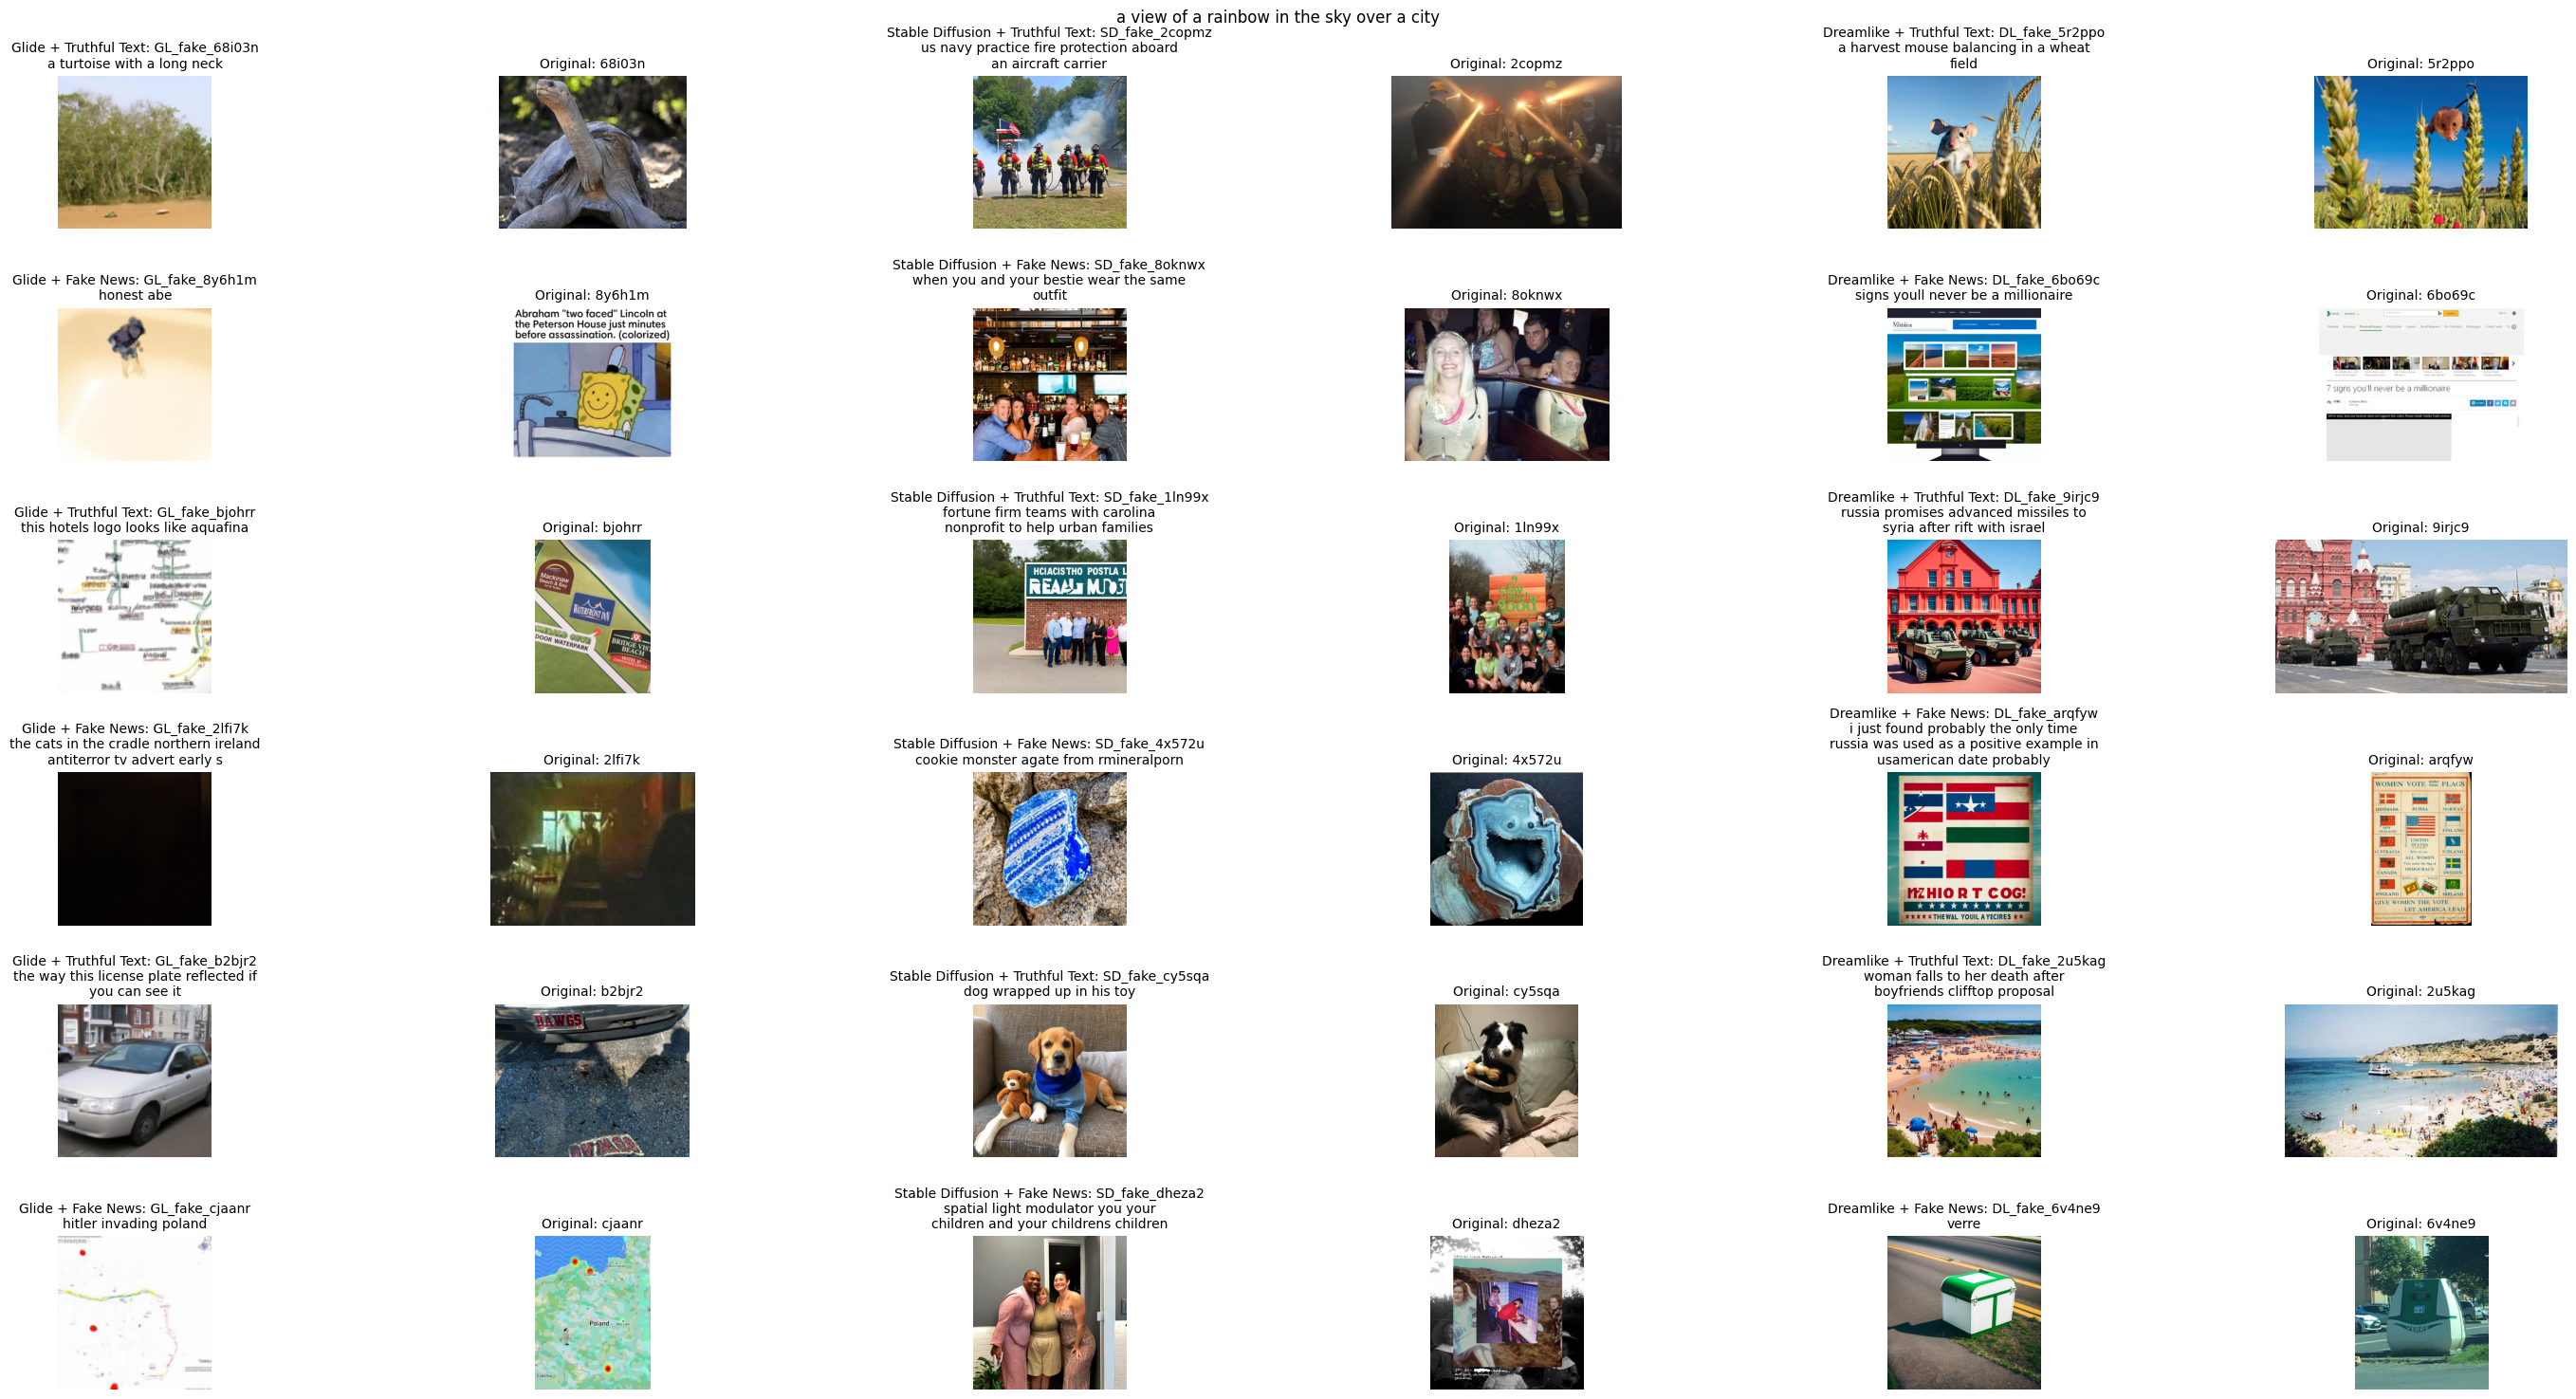

In [1]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random

def load_data_with_labels(file_path, caption_file_path):
    df = pd.read_csv(caption_file_path, delimiter=',', quotechar='"')
    caption_dict = pd.Series(df.original_caption.values, index=df.id).to_dict()
    fakenews_text_dict = pd.Series(df.fakenews_text.values, index=df.id).to_dict()

    with open(file_path, 'r') as file:
        names = [line.strip() for line in file.readlines()]

    categorized_data = {
        'Glide': {0: [], 1: []},
        'Stable Diffusion': {0: [], 1: []},
        'Dreamlike': {0: [], 1: []},
        'Pristine': {0: [], 1: []}
    }

    for name in names:
        fakenews_value = fakenews_text_dict.get(name.split('.')[0], None)
        if fakenews_value is None:
            continue  # skip if no label available

        if name.startswith('GL_'):
            categorized_data['Glide'][fakenews_value].append(name)
        elif name.startswith('SD_'):
            categorized_data['Stable Diffusion'][fakenews_value].append(name)
        elif name.startswith('DL_'):
            categorized_data['Dreamlike'][fakenews_value].append(name)
        else:
            categorized_data['Pristine'][fakenews_value].append(name)

    return categorized_data, caption_dict

def display_images_with_originals(categories, title, captions, num_images=3):
    fig, axs = plt.subplots(num_images * 2, 6, figsize=(30, num_images * 5)) 
    fig.suptitle(title)

    for i, key in enumerate(['Glide', 'Stable Diffusion', 'Dreamlike']):
        for fakenews_value in [0, 1]:
            image_list = categories[key][fakenews_value]
            random.shuffle(image_list)  # Shuffle list to get random images

            for j in range(num_images):
                generated_ax = axs[j * 2 + fakenews_value, i * 2]  # generated images
                original_ax = axs[j * 2 + fakenews_value, i * 2 + 1]  # original images

                if j < len(image_list):
                    generated_image_name = image_list[j]
                    original_image_name = generated_image_name.split('_')[-1] 

                    generated_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{generated_image_name}.jpg'
                    original_image_path = f'/home/enriconello/DeepFakeDetection/dataset_new/test_balanced/{original_image_name}.jpg'

                    # generated image
                    generated_img = mpimg.imread(generated_image_path)
                    generated_ax.imshow(generated_img, aspect='equal')

                    # original image
                    original_img = mpimg.imread(original_image_path)
                    original_ax.imshow(original_img, aspect='equal')

                    caption = captions.get(original_image_name, "Caption not found")
                    wrapped_caption = textwrap.fill(caption, width=40)

                    if fakenews_value == 0:
                        title_prefix = 'Truthful Text'
                    else:
                        title_prefix = 'Fake News'

                    generated_ax.set_title(f'{key} + {title_prefix}: {generated_image_name}\n{wrapped_caption}', fontsize=10)
                    original_ax.set_title(f'Original: {original_image_name}', fontsize=10)

                generated_ax.axis('off')
                original_ax.axis('off')

    plt.tight_layout()
    plt.show()


file_path_unimodal = '/home/enriconello/DeepFakeDetection/Thesis/6_result_analysis/misclassified_CLIP_not_RN50_BERT_multimodal.txt'
caption_file_path = '/home/enriconello/DeepFakeDetection/test_balanced/csv/test.csv'

unique_unimodal_categories_with_labels, captions = load_data_with_labels(file_path_unimodal, caption_file_path)

display_images_with_originals(unique_unimodal_categories_with_labels, 'a view of a rainbow in the sky over a city', captions)